# Runs two PathSim simulations of the arc fuel cycle: 
### -1. TES as a single 3 meter high BCR.
### -2. TES as three 1m high BCRs in series.  

In [11]:
import pathview
import json
from pathsim.blocks import Scope
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
from joblib import Parallel, delayed

# Simulation time
sim_time = 50 * 24 * 3600

##### Run each model inside its own worker to avoid pickling model objects #####

single_json = "ARC_with_single_BCR.json"
series_json = "ARC_with_series_BCRs.json"

def run_and_save(graph_json_path, out_npz_path, sim_time):
    """Create model in this process, run it, copy scope data to own-memory arrays and save .npz"""
    print(f"Running model from {graph_json_path}...")
    with open(graph_json_path, "r") as f:
        graph_data = json.load(f)
    model, duration = pathview.make_pathsim_model(graph_data)
    model.run(sim_time)

    save_dict = {}
    for block in model.blocks:
        if isinstance(block, Scope):
            try:
                t, data = block.read()
            except Exception:
                # some blocks may not expose read() in all contexts
                continue
            # Ensure each port timeseries is a copy that owns its data
            data_list = [np.array(port_ts, copy=True) for port_ts in data]
            labels = getattr(block, "labels", [f"port {i}" for i in range(len(data_list))])
            # store copies to ensure writable/owning arrays
            save_dict[f"{block.id}__time"] = np.array(t, copy=True) if t is not None else np.array([])
            save_dict[f"{block.id}__data"] = np.array(data_list, dtype=object)
            save_dict[f"{block.id}__labels"] = np.array(labels, dtype=object)

    out_file = Path(out_npz_path)
    if save_dict:
        np.savez_compressed(out_file, **save_dict)
        print(f"Saved simulation results to {out_file}")
    else:
        print("No scope data saved.")

print("Running models in parallel workers...")
Parallel(n_jobs=2)(delayed(run_and_save)(p, out, sim_time) for p, out in [
    (single_json, "arc_single_BCR_results.npz"),
    (series_json, "arc_series_BCRs_results.npz")
])

print("Workers finished.")

Running models in parallel workers...
Running model from ARC_with_single_BCR.json...
22:53:37 - INFO - LOGGING (log: True)
22:53:37 - INFO - BLOCKS (total: 39, dynamic: 10, static: 29, eventful: 1)
22:53:37 - INFO - GRAPH (nodes: 39, edges: 57, alg. depth: 6, loop depth: 0, runtime: 0.109ms)
Running model from ARC_with_series_BCRs.json...
22:53:37 - INFO - LOGGING (log: True)
22:53:37 - INFO - BLOCKS (total: 45, dynamic: 10, static: 35, eventful: 1)
22:53:37 - INFO - GRAPH (nodes: 45, edges: 77, alg. depth: 9, loop depth: 0, runtime: 0.092ms)
22:53:37 - INFO - STARTING -> TRANSIENT (Duration: 4320000.00s)
22:53:37 - INFO - STARTING -> TRANSIENT (Duration: 4320000.00s)
Running model from ARC_with_single_BCR.json...
22:53:37 - INFO - LOGGING (log: True)
22:53:37 - INFO - BLOCKS (total: 39, dynamic: 10, static: 29, eventful: 1)
22:53:37 - INFO - GRAPH (nodes: 39, edges: 57, alg. depth: 6, loop depth: 0, runtime: 0.109ms)
Running model from ARC_with_series_BCRs.json...
22:53:37 - INFO - LO

## Generate Plots

Loaded saved results from arc_single_BCR_results.npz
Loaded saved results from arc_series_BCRs_results.npz
Available scopes in saved_single:
  15
    port 0: blanket (inv)
    port 1: HX (inv)
    port 2: FW (inv)
    port 3: Divertor (inv)
    port 4: T seperation membrane (inv)
  16
    port 0: storage (inv)
    port 1: pump (inv)
    port 2: fuel cleanup (inv)
    port 3: ISS (inv)
  30
    port 0: fusion_reaction_rate
  50
    port 0: BCR 1 (eff)
  51
    port 0: BCR 1 (y_T2_out)
    port 1: y_T2_in
  52
    port 0: BCR 1 (c_T_out)
    port 1: c_T_in [mol/m3]
Available scopes in saved_series:
  15
    port 0: blanket (inv)
    port 1: HX (inv)
    port 2: FW (inv)
    port 3: Divertor (inv)
    port 4: T seperation membrane (inv)
  16
    port 0: storage (inv)
    port 1: pump (inv)
    port 2: fuel cleanup (inv)
    port 3: ISS (inv)
  30
    port 0: fusion_reaction_rate
  45
    port 0: BCR 1 (eff)
    port 1: BCR 2 (eff)
    port 2: BCR 3 (eff)
    port 3: Total efficiency
  46


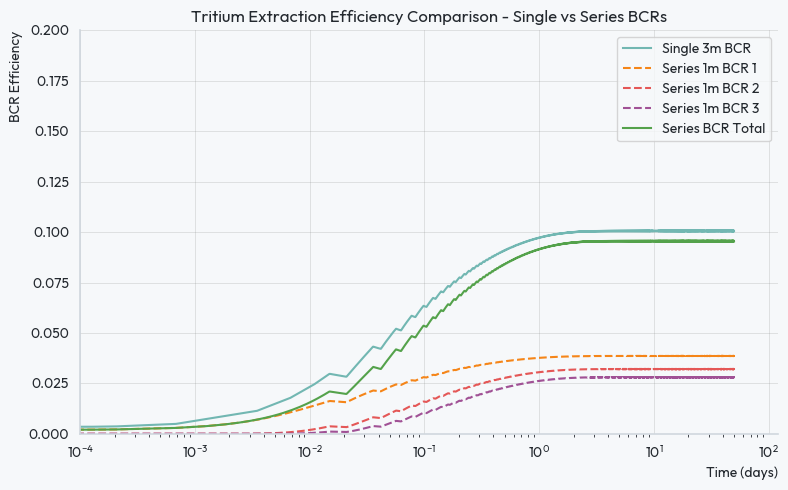

In [12]:
import morethemes as mt
import numpy as np

mt.set_theme("lighter")

# Load saved single & series BCR models results (saved by the worker processes)
from pathlib import Path
single_BCR_results_file = Path("arc_single_BCR_results.npz")
series_BCR_results_file = Path("arc_series_BCRs_results.npz")

saved_single = None
if single_BCR_results_file.exists():
    saved_single = np.load(single_BCR_results_file, allow_pickle=True)
    print(f"Loaded saved results from {single_BCR_results_file}")
else:
    print(f"Saved results not found at {single_BCR_results_file}")

saved_series = None
if series_BCR_results_file.exists():
    saved_series = np.load(series_BCR_results_file, allow_pickle=True)
    print(f"Loaded saved results from {series_BCR_results_file}")
else:
    print(f"Saved results not found at {series_BCR_results_file}")

def list_scope_ids(saved):
    if saved is None:
        return []
    ids = set()
    for k in saved.files:
        if k.endswith('__data'):
            ids.add(k.split('__')[0])
    return sorted(ids)

def list_scope_info(saved):
    """Return list of (scope_id, labels_or_None) for a loaded npz file."""
    if saved is None:
        return []
    info = []
    for sid in list_scope_ids(saved):
        lbl_key = f"{sid}__labels"
        if lbl_key in saved:
            labels = [str(x) for x in np.array(saved[lbl_key], dtype=object)]
        else:
            labels = None
        info.append((sid, labels))
    return info

print('Available scopes in saved_single:')
for sid, labels in list_scope_info(saved_single):
    print(f"  {sid}")
    if labels:
        for i, lb in enumerate(labels):
            print(f"    port {i}: {lb}")
    else:
        print("    (no labels)")

print('Available scopes in saved_series:')
for sid, labels in list_scope_info(saved_series):
    print(f"  {sid}")
    if labels:
        for i, lb in enumerate(labels):
            print(f"    port {i}: {lb}")
    else:
        print("    (no labels)")

# Helper to extract scope data from loaded npz
def get_from_saved(saved, scope_id):
    if saved is None or scope_id is None:
        return None, []
    tid = f"{scope_id}__time"
    did = f"{scope_id}__data"
    if tid in saved and did in saved:
        sim_time = np.array(saved[tid])
        data_arr = saved[did]  # object array: ports x times
        data_list = [np.array(row) for row in data_arr]
        return sim_time, data_list
    return None, []

# Select scope ids from the saved files. Adjust indices for specific scope.
single_ids = list_scope_ids(saved_single)
series_ids = list_scope_ids(saved_series)

if not single_ids:
    raise RuntimeError('No scopes found in saved single-BCR results; re-run simulation or inspect files.')
if not series_ids:
    raise RuntimeError('No scopes found in saved series-BCR results; re-run simulation or inspect files.')

# By default pick the first scope in each file. If you need a different scope, replace these.
single_scope_id = single_ids[3]
series_scope_id = series_ids[3]

single_BCR_sim_time, single_BCR_data_list = get_from_saved(saved_single, single_scope_id)
series_BCR_sim_time, series_BCR_data_list = get_from_saved(saved_series, series_scope_id)

single_BCR_time = np.ravel(single_BCR_sim_time) if single_BCR_sim_time is not None else np.array([])
series_BCR_time = np.ravel(series_BCR_sim_time) if series_BCR_sim_time is not None else np.array([])

# The saved data_list contains one entry per scope port. Adjust indices if your scope ports differ.
single_BCR_efficiency = np.ravel(np.array(single_BCR_data_list[0])) if single_BCR_data_list else np.array([])

# For the series case we assume ports 0..2 are the three 1m BCRs and port 3 is the total (adjust if needed).
series_BCR_1_efficiency = np.ravel(np.array(series_BCR_data_list[0])) if len(series_BCR_data_list) > 0 else np.array([])
series_BCR_2_efficiency = np.ravel(np.array(series_BCR_data_list[1])) if len(series_BCR_data_list) > 1 else np.array([])
series_BCR_3_efficiency = np.ravel(np.array(series_BCR_data_list[2])) if len(series_BCR_data_list) > 2 else np.array([])
series_BCR_total_efficiency = np.ravel(np.array(series_BCR_data_list[3])) if len(series_BCR_data_list) > 3 else np.array([])

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1)
if single_BCR_time.size and single_BCR_efficiency.size:
    ax.plot(single_BCR_time / 3600.0 / 24.0, single_BCR_efficiency, label="Single 3m BCR", ls='-')
if series_BCR_time.size and series_BCR_1_efficiency.size:
    ax.plot(series_BCR_time / 3600.0 / 24.0, series_BCR_1_efficiency, label="Series 1m BCR 1", ls='--')
if series_BCR_time.size and series_BCR_2_efficiency.size:
    ax.plot(series_BCR_time / 3600.0 / 24.0, series_BCR_2_efficiency, label="Series 1m BCR 2", ls='--')
if series_BCR_time.size and series_BCR_3_efficiency.size:
    ax.plot(series_BCR_time / 3600.0 / 24.0, series_BCR_3_efficiency, label="Series 1m BCR 3", ls='--')
if series_BCR_time.size and series_BCR_total_efficiency.size:
    ax.plot(series_BCR_time / 3600.0 / 24.0, series_BCR_total_efficiency, label="Series BCR Total", ls='-')
ax.set_xlabel("Time (days)")
ax.set_ylabel("BCR Efficiency")
ax.set_xscale("log")
ax.set_ylim(0,0.2)
ax.set_xlim(left=1e-4)
ax.legend(loc='best')
ax.set_title("Tritium Extraction Efficiency Comparison - Single vs Series BCRs")
fig.tight_layout()
plt.show()